# Practice notebook for making fits on sphere

In [1]:
import numpy as np
from numpy.linalg import inv, solve

import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
import matplotlib.pyplot as plt
from scipy import interpolate
from mpl_toolkits.mplot3d import Axes3D
import cartopy.crs as ccrs
import mplstereonet

import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

%matplotlib inline 
%config InlineBackend.figure_formats = {'svg',}

In [2]:
d2r = np.pi / 180.
r2d = 180. / np.pi

def rotate(pole, rotation_pole, angle):
    # The idea is to rotate the pole so that the Euler pole is
    # at the pole of the coordinate system, then perform the
    # requested rotation, then restore things to the original
    # orientation
    lon, lat, norm = cartesian_to_spherical(rotation_pole)
    colat = 90. - lat
    m1 = construct_euler_rotation_matrix(-lon[0]
                                         * d2r, -colat[0] * d2r, angle * d2r)
    m2 = construct_euler_rotation_matrix(0., colat[0] * d2r, lon[0] * d2r)
    return np.dot(m2, np.dot(m1, pole))


def construct_euler_rotation_matrix(alpha, beta, gamma):
    """
    Make a 3x3 matrix which represents a rigid body rotation,
    with alpha being the first rotation about the z axis,
    beta being the second rotation about the y axis, and
    gamma being the third rotation about the z axis.

    All angles are assumed to be in radians
    """
    rot_alpha = np.array([[np.cos(alpha), -np.sin(alpha), 0.],
                          [np.sin(alpha), np.cos(alpha), 0.],
                          [0., 0., 1.]])
    rot_beta = np.array([[np.cos(beta), 0., np.sin(beta)],
                         [0., 1., 0.],
                         [-np.sin(beta), 0., np.cos(beta)]])
    rot_gamma = np.array([[np.cos(gamma), -np.sin(gamma), 0.],
                          [np.sin(gamma), np.cos(gamma), 0.],
                          [0., 0., 1.]])
    rot = np.dot(rot_gamma, np.dot(rot_beta, rot_alpha))
    return rot


def spherical_to_cartesian(longitude, latitude, norm):
    #    assert(np.all(longitude >= 0.) and np.all(longitude <= 360.))
    #    assert(np.all(latitude >= -90.) and np.all(latitude <= 90.))
    #    assert(np.all(norm >= 0.))
    colatitude = 90. - latitude
    return np.array([norm * np.sin(colatitude * d2r) * np.cos(longitude * d2r),
                     norm * np.sin(colatitude * d2r) * np.sin(longitude * d2r),
                     norm * np.cos(colatitude * d2r)])
def cartesian_to_spherical(vecs):
#     v = np.reshape(vecs, (3, -1))

    v = vecs
    norm = np.sqrt(v[0, :] * v[0, :] + v[1, :] * v[1, :] + v[2, :] * v[2, :])
    latitude = 90. - np.arccos(v[2, :] / norm) * r2d
    longitude = np.arctan2(v[1, :], v[0, :]) * r2d
    return longitude, latitude, norm

## spline line through 3d points

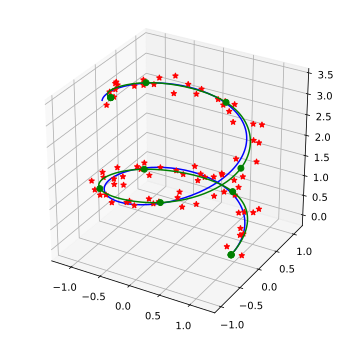

In [3]:
# 3D example
total_rad = 10
z_factor = 3
noise = 0.1

num_true_pts = 200
s_true = np.linspace(0, total_rad, num_true_pts)
x_true = np.cos(s_true)
y_true = np.sin(s_true)
z_true = s_true/z_factor

num_sample_pts = 80
s_sample = np.linspace(0, total_rad, num_sample_pts)
x_sample = np.cos(s_sample) + noise * np.random.randn(num_sample_pts)
y_sample = np.sin(s_sample) + noise * np.random.randn(num_sample_pts)
z_sample = s_sample/z_factor + noise * np.random.randn(num_sample_pts)

tck, u = interpolate.splprep([x_sample,y_sample,z_sample], s=2)
x_knots, y_knots, z_knots = interpolate.splev(tck[0], tck)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

fig2 = plt.figure(figsize=(6,6))
ax3d = fig2.add_subplot(111, projection='3d')
ax3d.plot(x_true, y_true, z_true, 'b')
ax3d.plot(x_sample, y_sample, z_sample, 'r*')
ax3d.plot(x_knots, y_knots, z_knots, 'go')
ax3d.plot(x_fine, y_fine, z_fine, 'g')
fig2.show()
plt.show()

In [4]:
lon, lat, norms = cartesian_to_spherical(np.array([x_sample, y_sample, z_sample]))

In [5]:
interp_lon, interp_lat, interp_norms = cartesian_to_spherical(np.array([x_fine, y_fine, z_fine]))

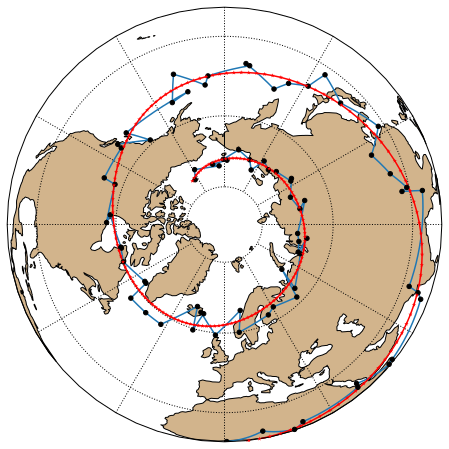

In [6]:
map_axis = ipmag.make_orthographic_map(central_latitude=90)
ipmag.plot_vgp(map_axis, lon, lat)
map_axis.plot(lon, lat,  transform=ccrs.Geodetic())

ipmag.plot_vgp(map_axis, interp_lon, interp_lat, color = 'r', marker = '*', edge = "none")
map_axis.plot(interp_lon, interp_lat,  color = 'r', transform=ccrs.Geodetic())

## fit girdle through points

In [7]:
x = np.linspace(0, 100, 50)
y = np.random.normal(scale = 5, size = 50)
strike, dip = mplstereonet.geographic2pole(x*d2r, y*d2r)
fit_strike, fit_dip = mplstereonet.fit_girdle(strike, dip)

fit_lon, fit_lat = mplstereonet.pole(fit_strike, fit_dip)

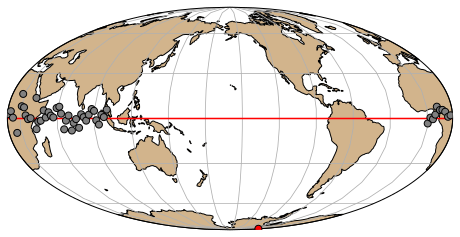

In [8]:
# map_axis_1 = ipmag.make_orthographic_map(central_latitude=30, central_longitude=200)
map_axis_1 = ipmag.make_mollweide_map(central_longitude=200)

ipmag.plot_vgp(map_axis_1, x, y, color = 'grey', markersize = 50)

ipmag.plot_vgp(map_axis_1, fit_lon*r2d, fit_lat*r2d, color = 'r', markersize = 50)
# ipmag.plot_vgp(map_axis_1, 210, vgp_lat = -65, color = 'r', markersize = 50)

map_axis_1.plot(np.linspace(0,360, 100), np.zeros(100),  color = 'r', transform=ccrs.Geodetic());

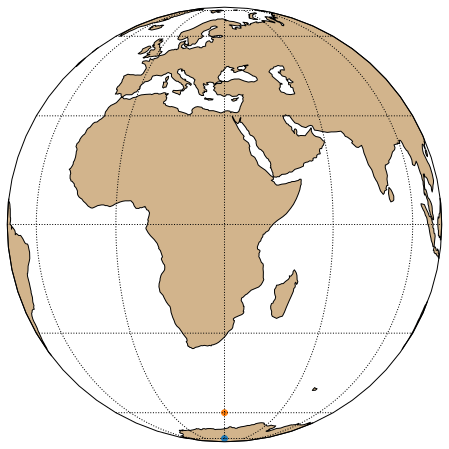

In [9]:
# map_axis_1 = ipmag.make_orthographic_map(central_latitude=30, central_longitude=200)
map_axis_1 = ipmag.make_orthographic_map(central_longitude=30, central_latitude=0)

# ipmag.plot_vgp(map_axis_1, 30, -80, color = 'r', markersize = 50)
map_axis_1.scatter(30, -80, transform=ccrs.Geodetic())
map_axis_1.scatter(30, -60, transform=ccrs.PlateCarree())

In [10]:
fit_lon*r2d, fit_lat*r2d

(array([7.12328938]), array([-87.30460409]))

In [11]:
lon = np.linspace(0,360,100)
lat = np.zeros(100)
diblock = np.array([[i,j] for i, j in zip(lon, lat)])
# diblock
rotated = pmag.dodirot_V(diblock, fit_lon*r2d, fit_lat*r2d)
# rotated
# ipmag.unpack_di_block(rotated)
rot_lon, rot_lat, _ = ipmag.unpack_di_block(rotated)



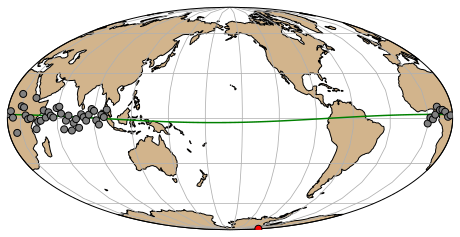

In [12]:
map_axis_1 = ipmag.make_mollweide_map(central_longitude=200)

ipmag.plot_vgp(map_axis_1, x, y, color = 'grey', markersize = 50)

ipmag.plot_vgp(map_axis_1, fit_lon*r2d, fit_lat*r2d, color = 'r', markersize = 50)
# ipmag.plot_vgp(map_axis_1, 210, vgp_lat = -65, color = 'r', markersize = 50)

map_axis_1.plot(rot_lon, rot_lat, color = 'g', transform=ccrs.Geodetic());

In [13]:
pmag.pt_rot??

Signature: pmag.pt_rot(EP, Lats, Lons)
Source:   
def pt_rot(EP, Lats, Lons):
    """
    Rotates points on a globe by an Euler pole rotation using method of
    Cox and Hart 1986, box 7-3.

    Parameters
    ----------
    EP : Euler pole list [lat,lon,angle] specifying the location of the pole;
    the angle is for a counterclockwise rotation about the pole
    Lats : list of latitudes of points to be rotated
    Lons : list of longitudes of points to be rotated

    Returns
    _________
    RLats : list of rotated latitudes
    RLons : list of rotated longitudes
    """
# gets user input of Rotation pole lat,long, omega for plate and converts
# to radians
    E = dir2cart([EP[1], EP[0], 1.])  # EP is pole lat,lon omega
    omega = np.radians(EP[2])  # convert to radians
    RLats, RLons = [], []
    for k in range(len(Lats)):
        if Lats[k] <= 90.:  # peel off delimiters
            # converts to rotation pole to cartesian coordinates
            A = dir2cart([Lons[k], Lats[k]

In [14]:
one_Euler_pole_lon = np.loadtxt('pole_lon_positions1.txt')
one_Euler_pole_lat = np.loadtxt('pole_lat_positions1.txt')

len(one_Euler_pole_lon)

1000

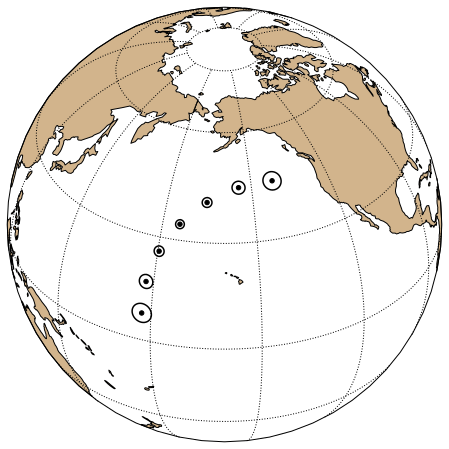

In [15]:
m = ipmag.make_orthographic_map(central_latitude=35,central_longitude=200)
# m.add_feature(Laurentia_outline)
plt.figure(num=1,figsize=(10, 10))

one_Euler_mean_pole_lon = []
one_Euler_mean_pole_lat = []


for i in range(len(one_Euler_pole_lon[0])):
    this_fisher = ipmag.fisher_mean(one_Euler_pole_lon[:,i]+180,one_Euler_pole_lat[:,i])
    this_theta = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,i]+180,one_Euler_pole_lat[:,i])
    ipmag.plot_pole(m,this_fisher['dec'],this_fisher['inc'],this_theta)
    one_Euler_mean_pole_lon.append(this_fisher['dec'])
    one_Euler_mean_pole_lat.append(this_fisher['inc'])
#     plt.show()

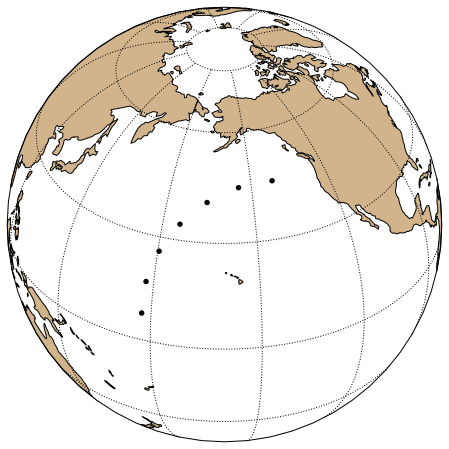

In [16]:
m = ipmag.make_orthographic_map(central_latitude=35,central_longitude=200)
# m.add_feature(Laurentia_outline)
plt.figure(num=1,figsize=(10, 10))

ipmag.plot_vgp(m, one_Euler_mean_pole_lon, one_Euler_mean_pole_lat)


In [17]:
euler_di_blocks = ipmag.make_di_block(one_Euler_mean_pole_lon, one_Euler_mean_pole_lat)
euler_cart = pmag.dir2cart(euler_di_blocks)
euler_cart

array([[-0.55159741, -0.43372721,  0.71247526],
       [-0.64362387, -0.30302385,  0.70279789],
       [-0.73624319, -0.18267434,  0.65159501],
       [-0.82279495, -0.0813267 ,  0.5624895 ],
       [-0.89705598, -0.0062657 ,  0.44187251],
       [-0.95370923,  0.03713601,  0.2984286 ],
       [-0.9887372 ,  0.04581344,  0.14247762]])

In [18]:
euler_di_blocks

[[218.17836582860136, 45.436667881756094, 1.0],
 [205.21147375219536, 44.651912049918934, 1.0],
 [193.93464904287293, 40.6619669281571, 1.0],
 [185.64489410721006, 34.228138976924356, 1.0],
 [180.40018938628526, 26.223415627688876, 1.0],
 [177.77011452295022, 17.363245620299324, 1.0],
 [177.34707988182242, 8.191240879546955, 1.0]]

In [19]:
euler_cart_T = np.array(euler_cart).T

In [20]:
def spheres(size, dist=0): 
    
    # Set up 100 points. First, do angles
    theta = np.linspace(0,2*np.pi,100)
    phi = np.linspace(0,np.pi,100)
    
    # Set up coordinates for points on the sphere
    x0 = dist + size * np.outer(np.cos(theta),np.sin(phi))
    y0 = size * np.outer(np.sin(theta),np.sin(phi))
    z0 = size * np.outer(np.ones(100),np.cos(phi))
    
    # Set up trace
    trace= go.Surface(x=x0, y=y0, z=z0, colorscale=[[0,'#E5E8E8'], [1,'#E5E8E8']], opacity=1.0)
    trace.update(showscale=False)

    return trace

In [21]:
unit_sphere = spheres(1)

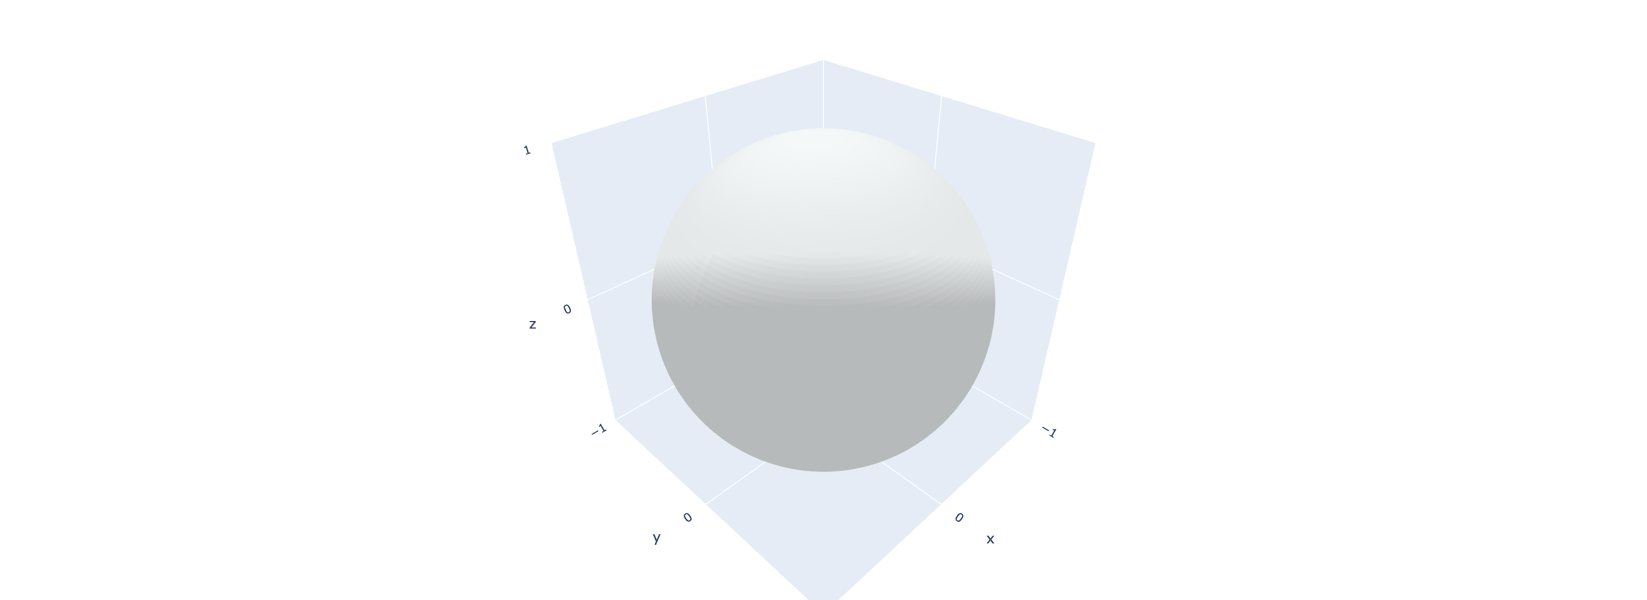

In [22]:
fig = go.Figure()
data_scatter = go.Scatter3d(x=euler_cart_T[0], y=euler_cart_T[1], z=euler_cart_T[2],
                            mode="markers",
                            marker=dict(size=2))
fig.add_trace(unit_sphere)
fig.add_trace(data_scatter)

fig.update_layout(margin=dict(l=0, r=0, t=0, b=0),  
                  scene = dict(
                      xaxis = dict(nticks=4, range=[-1, 1],),
                     yaxis = dict(nticks=4, range=[-1, 1],),
                     zaxis = dict(nticks=4, range=[-1, 1],),),
                  height=600)

fig

In [23]:
def least_squares_by_inv(X, Y):
    return inv(X.T @ X) @ X.T @ Y

def least_squares_by_solve(X, Y):
    return solve(X.T @ X, X.T @ Y)

def add_ones_column(X):
    return np.hstack([np.ones((X.shape[0],1)), X])

def model_append_ones(X):
    return add_ones_column(X) @ theta_hat

def plot_plane(f, X, grid_points = 30):
    u = np.linspace(X[:,0].min(),X[:,0].max(), grid_points)
    v = np.linspace(X[:,1].min(),X[:,1].max(), grid_points)
    xu, xv = np.meshgrid(u,v)
    X = np.vstack((xu.flatten(),xv.flatten())).transpose()
    z = f(X)
    return go.Surface(x=xu, y=xv, z=z.reshape(xu.shape),colorscale=[[0,'#E5E8E8'], [1,'#E5E8E8']], opacity=1)

In [38]:
def get_rho(A, B, C, D):
    return -D/np.sqrt(A**2+B**2+C**2)

def get_circle_center(A, B, C, D):
    rho = get_rho(A, B, C, D)
    center = rho/np.sqrt(A**2+B**2+C**2)*np.array([A, B, C])
    return center


In [25]:
euler_cart

array([[-0.55159741, -0.43372721,  0.71247526],
       [-0.64362387, -0.30302385,  0.70279789],
       [-0.73624319, -0.18267434,  0.65159501],
       [-0.82279495, -0.0813267 ,  0.5624895 ],
       [-0.89705598, -0.0062657 ,  0.44187251],
       [-0.95370923,  0.03713601,  0.2984286 ],
       [-0.9887372 ,  0.04581344,  0.14247762]])

In [26]:
X = np.delete(euler_cart, 2, 1)
# X = add_ones_column(X)
X

array([[-0.55159741, -0.43372721],
       [-0.64362387, -0.30302385],
       [-0.73624319, -0.18267434],
       [-0.82279495, -0.0813267 ],
       [-0.89705598, -0.0062657 ],
       [-0.95370923,  0.03713601],
       [-0.9887372 ,  0.04581344]])

In [27]:
Y = np.array(euler_cart[:,2])
Y

array([0.71247526, 0.70279789, 0.65159501, 0.5624895 , 0.44187251,
       0.2984286 , 0.14247762])

In [28]:
theta_hat = least_squares_by_solve(add_ones_column(X), Y)
theta_hat

array([5.28490565, 5.37289477, 3.70915158])

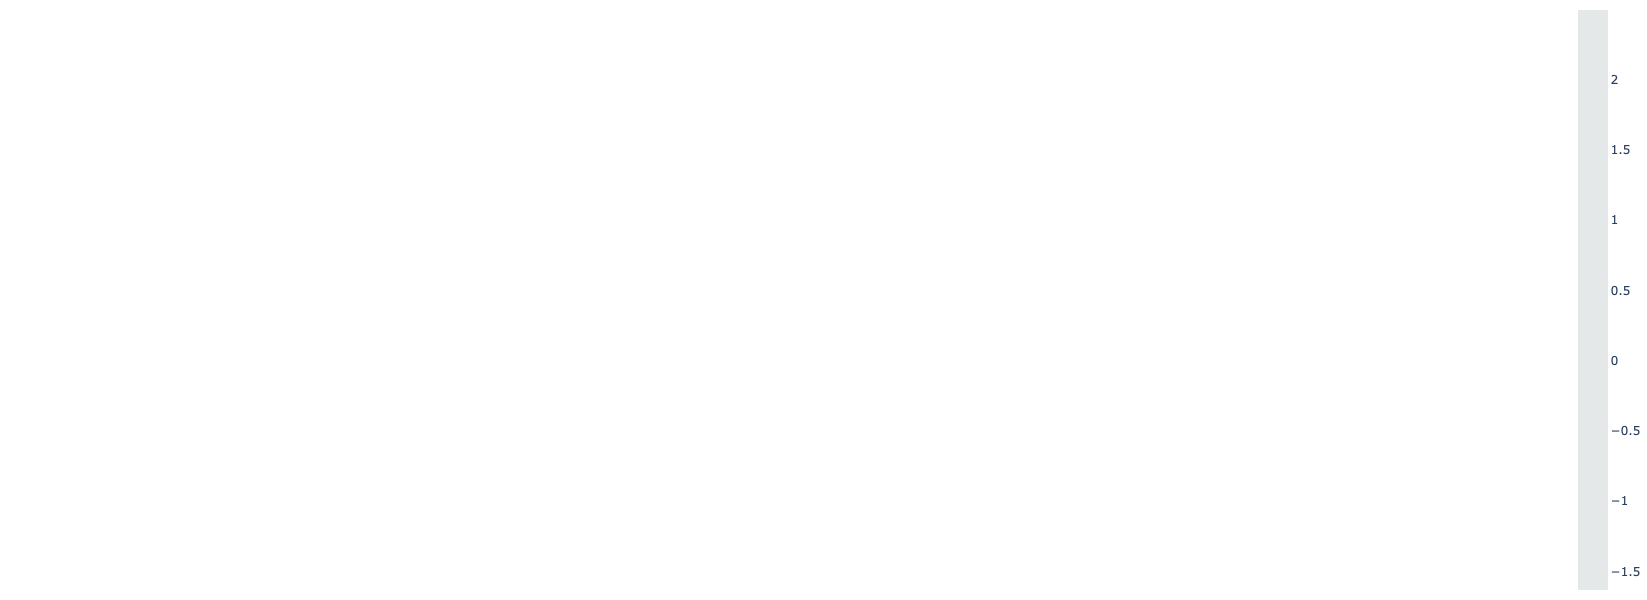

In [29]:
fig = go.Figure()
fig.add_trace(data_scatter)
# fig.add_trace(unit_sphere)
fig.add_trace(plot_plane(model_append_ones, X))
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0),  
                  scene = dict(
                      xaxis = dict(nticks=4, range=[-3, 3],),
                     yaxis = dict(nticks=4, range=[-3, 3],),
                     zaxis = dict(nticks=4, range=[-3, 3],)),
                  height=600)

In [39]:
def make_small_circle(d, k):
    alpha = np.linspace(0, 2*np.pi, 100)
    beta = np.arctan(k*np.sin(alpha))-np.arcsin(d*np.sqrt(1+k**2)/(1+(k*np.sin(alpha))**2))
    
    return alpha*180/np.pi, beta*180/np.pi



In [40]:
def rodrigues_rot(P, n0, n1):
    
    # If P is only 1d array (coords of single point), fix it to be matrix
    if P.ndim == 1:
        P = P[np.newaxis,:]
    
    # Get vector of rotation k and angle theta
    n0 = n0/np.linalg.norm(n0)
    n1 = n1/np.linalg.norm(n1)
    k = np.cross(n0,n1)
    k = k/np.linalg.norm(k)
    theta = np.arccos(np.dot(n0,n1))
    
    # Compute rotated points
    P_rot = np.zeros((len(P),3))
    for i in range(len(P)):
        P_rot[i] = P[i]*np.cos(theta) + np.cross(k,P[i])*np.sin(theta) + k*np.dot(k,P[i])*(1-np.cos(theta))

    return P_rot

In [41]:
D, A, B, C = theta_hat[0], theta_hat[1], theta_hat[2], 1
rho = get_rho(A, B, C, D)
circle_center = get_circle_center(A, B, C, D)
print(rho)
print(circle_center)

-0.8001391462581536
[-0.65088181 -0.44933307 -0.12114174]


In [51]:
center = get_circle_center(A, B, -C, D)
center_dir = pmag.cart2dir(center)
center_dir

array([214.6190687 ,   8.70811591,   0.80013915])

In [52]:

a1, b1 = make_small_circle(rho, 0)
# a2, b2 = make_small_circle(0.6, 0)
# a3, b3 = make_small_circle(0.4, 0)

In [54]:
small_circle_block = ipmag.make_di_block(a1, b1)

small_circle_cart = pmag.dir2cart(small_circle_block)

small_circle_cart_rot = rodrigues_rot(small_circle_cart, np.array([0,0,1]), center)
small_circle_dir_rot = pmag.cart2dir(small_circle_cart_rot)
# small_circle_dir_rot.T

In [55]:
testpoint_rot_cart = rodrigues_rot(np.array([0,0,1]), np.array([0,0,1]), center)
testpoint_rot_dir = pmag.cart2dir(testpoint_rot_cart).T
testpoint_rot_dir

array([[214.6190687 ],
       [  8.70811591],
       [  1.        ]])

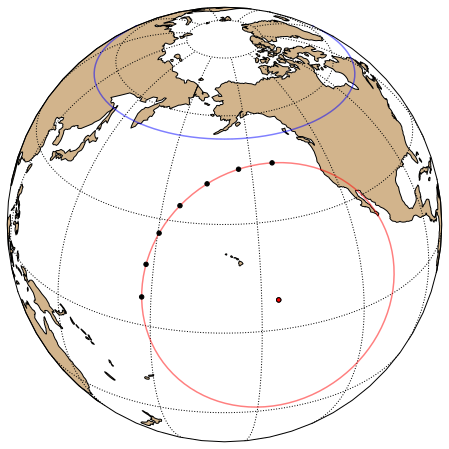

In [56]:
m = ipmag.make_orthographic_map(central_latitude=30,central_longitude=200)
# m.add_feature(Laurentia_outline)
plt.figure(num=1,figsize=(10, 10))

ipmag.plot_vgp(m, center_dir[0], center_dir[1])
ipmag.plot_vgp(m, testpoint_rot_dir[0], testpoint_rot_dir[1], color = 'red')

ipmag.plot_vgp(m, one_Euler_mean_pole_lon, one_Euler_mean_pole_lat)
m.plot(a1, b1,color='b', transform=ccrs.Geodetic(), alpha=0.5)

m.plot(small_circle_dir_rot.T[0], small_circle_dir_rot.T[1],color='r', transform=ccrs.Geodetic(), alpha=0.5)
# m.plot(a2, b2,color='b', transform=ccrs.Geodetic(), alpha=0.5)
# m.plot(a3, b3,color='b', transform=ccrs.Geodetic(), alpha=0.5)
